# Week 4 - classification



## Agenda

1. What is classification?
2. Logistic Regression
3. Evaluating a classification model
4. k-Nearest-Neighbor


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# read ISLP default data
df = pd.read_csv(
    "https://raw.githubusercontent.com/intro-stat-learning/ISLP/main/ISLP/data/Default.csv"
)

In [3]:
def plot_decision_boundary(x1, x2, y, model, thresholds=[0.5], figsize=(7, 7), ax=None, title=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)

    x1_min, x1_max = x1.min(), x1.max()
    x2_min, x2_max = x2.min(), x2.max()
    xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 1_000), np.linspace(x2_min, x2_max, 1_000))

    mesh_df = pd.DataFrame({
        x1.name: xx.ravel(),
        x2.name: yy.ravel()
    })

    Z = model.predict_proba(mesh_df)[:, 1]
    Z = Z.reshape(xx.shape)

    ax.contour(xx, yy, Z, levels=thresholds, cmap="Greys", vmin=0, vmax=0.6)

    sns.scatterplot(
        x=x1,
        y=x2,
        hue=y,
        alpha=0.5,
        edgecolor="white",
        linewidth=1,
        ax=ax
    )

    if title:
        ax.set_title(title)

## Analysis and cleaning

### Looking at data

In [4]:
df.sample(10)

,default,student,balance,income
6465,No,No,0.000000,36201.538873
9787,No,Yes,0.000000,20195.002659
4718,No,Yes,1269.226506,18552.424140
1832,Yes,Yes,1790.360537,14306.823602
327,No,No,729.047433,35042.132997
4841,No,No,671.732606,26431.272598
6214,No,Yes,1208.144482,17721.293662
8857,No,No,390.980824,47083.431497
3513,No,Yes,444.025308,23691.983217
9234,No,No,848.605387,22749.647676


In [5]:
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


There's one more thing we should always check when dealing with classification problems - how unbalanced are our classes? Perfectly balanced classes (that is, each class is 50% of the dataset) don't exist in the real world, and most problems actually have quite severe imbalance. That's because we're often interested in predicting events that are quite rate.


In [7]:
df.value_counts("default")

default
No     9667
Yes     333
Name: count, dtype: int64

Only about 3.3 % of all observations in the dataset have defaulted. This will be a problem that we'll have to get back to later.

### Transforming

The dataset is quite clean. The only transformation I want to apply is converting the `student` and `default` columns into binary 0/1 instead of Yes/No.


In [8]:
value_map = {"Yes": 1, "No": 0}
df["student"] = df["student"].map(value_map)
df["default"] = df["default"].map(value_map)

### Plotting

Let's visually investigate the relationship between the target variable `default` and the predictors.


<Axes: xlabel='balance', ylabel='Density'>

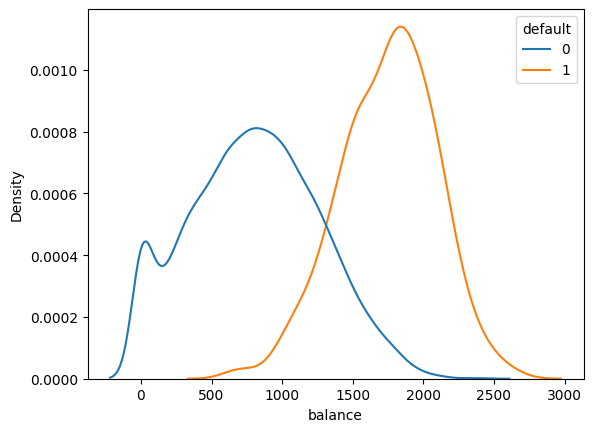

In [9]:
sns.kdeplot(data=df, x="balance", hue="default", common_norm=False)

<Axes: xlabel='income', ylabel='Density'>

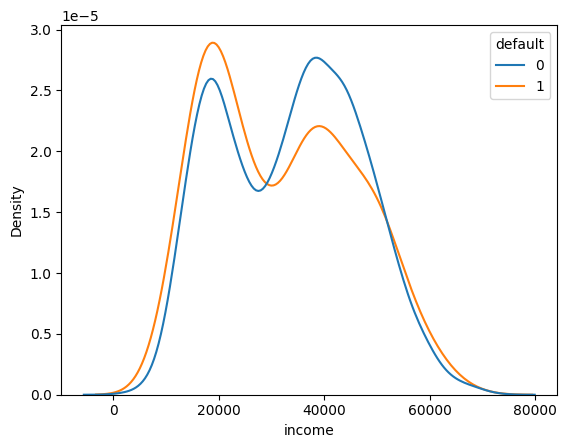

In [10]:
sns.kdeplot(data=df, x="income", hue="default", common_norm=False)

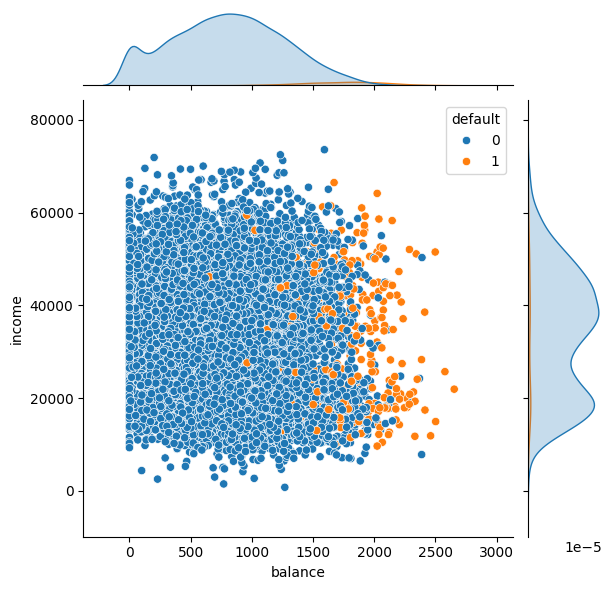

In [11]:
sns.jointplot(data=df, x="balance", y="income", hue="default")

The plot is quite crowded, and you can barely see any values that have default=1, because the default=0 values overwhelm it.

Let's improve this.


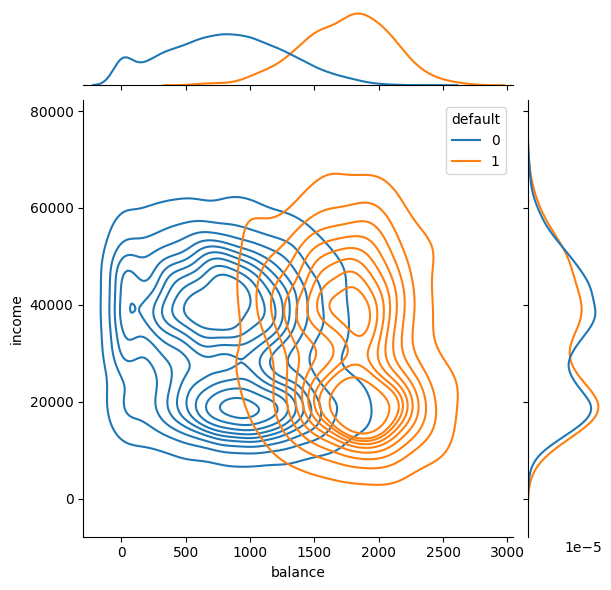

In [12]:
sns.jointplot(
    data=df,
    x="balance",
    y="income",
    hue="default",
    kind="kde",
    common_norm=False,
    marginal_kws={"common_norm": False},
)

A way better plot!


In [13]:
df.groupby("student")["default"].mean()

student
0    0.029195
1    0.043139
Name: default, dtype: float64

## Modelling


In [14]:
from sklearn.model_selection import train_test_split


We will now split the dataset into train, validation and test sets. You are already familiar with training and validation datasets - the training set is for training the model, while the validation set is for checking how different models perform on unseen data. The test set is for reporting the performance of the final model. We only make predictions on the test set using the final model that we chose based on how it performs on the test set. 



In [15]:
# First split into train and test (80/20)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=10)

# Then split off a validation set from the training set (75/25, which is 60/20 of original)
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=10)


In [16]:
target = "default"
y_train = df_train[target]